In [43]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures

In [31]:
df = pd.read_csv('../data/weather_train_merged.csv')
df['date'] = pd.to_datetime(df['date'])

Let's first start off our feature engineering by taking a look at the correlation within our merged dataframe.

In [75]:
def plot_heatmap(df):
    plt.figure(figsize=(22,22))

    mask = np.zeros_like(df.corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(df.corr(), mask=mask, annot=True, 
                annot_kws={'size': 13}, cmap='coolwarm', 
                vmin=-1, vmax=1, square=True, fmt='.1g', 
                cbar_kws={'shrink':0.8}, center=0);

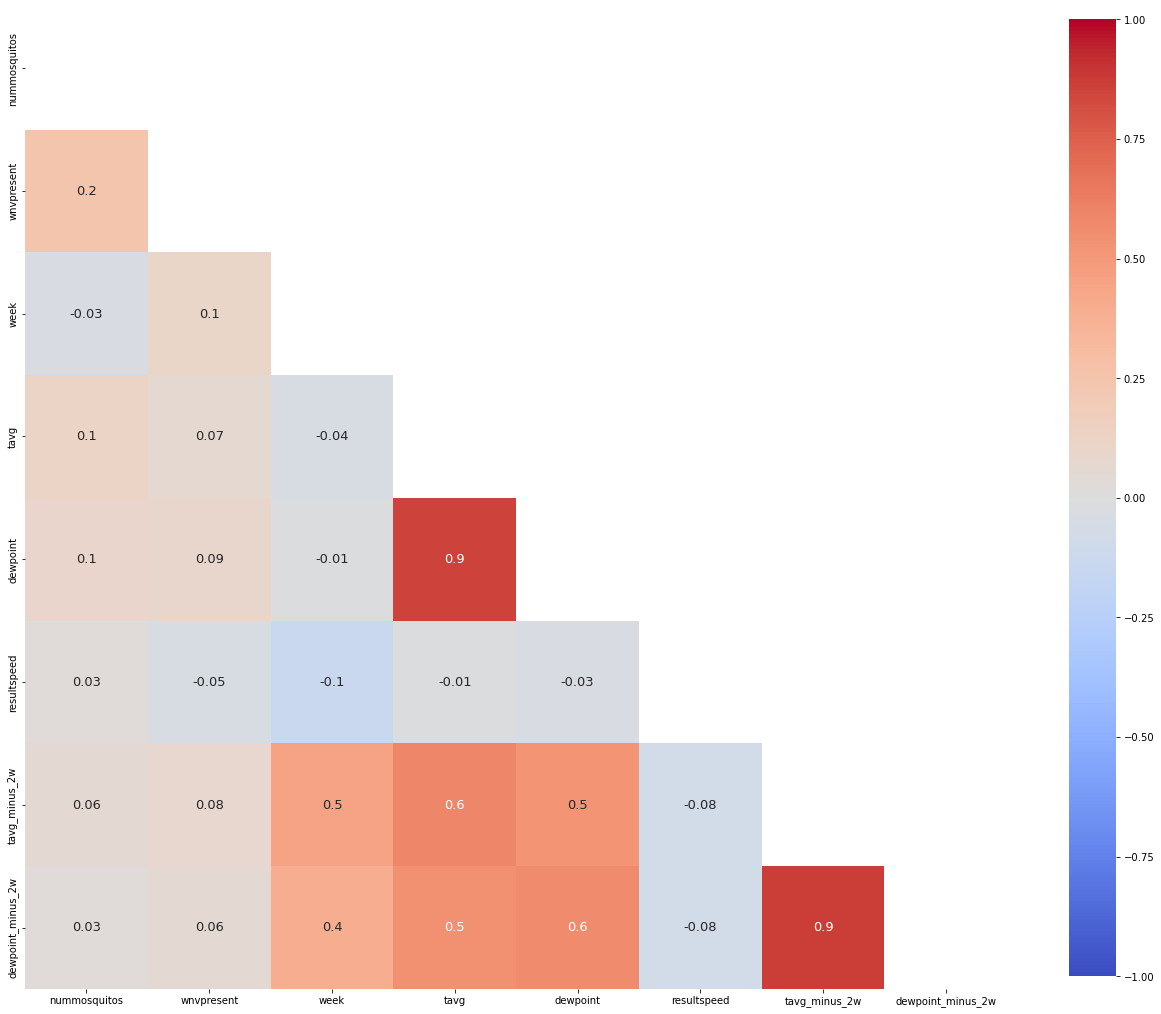

In [76]:
plot_heatmap(df)

From the above, we can see that most of our features have very low correlation with our target `wnvpresent`. The highest correlation observed is of a value of 0.1. As such, we will attempt some feature engineering to increase the correlation of our features. <br>

Additionally, we will use the above heatmap to conduct a preliminary feature selection process, and refer back to this heatmap to remove any features with pairwise correlation. An example of this would be `dewpoint` and `wetbulb`. 

In [33]:
abs(df.corr()['wnvpresent']).sort_values(ascending=False)

wnvpresent         1.000000
nummosquitos       0.248242
week               0.104807
month              0.101115
dewpoint           0.087043
wetbulb            0.082887
tmin               0.070538
longitude          0.068600
tavg               0.065243
station            0.063496
cool               0.059307
heat               0.054685
year               0.053875
tmax               0.051986
resultspeed        0.045893
latitude           0.033330
avgspeed           0.031990
preciptotal        0.014298
addressaccuracy    0.012268
weekday            0.011084
block              0.009204
sealevel           0.007648
stnpressure        0.006849
resultdir          0.000253
Name: wnvpresent, dtype: float64

We can see that there are some features missing from this list, like `trap`. We will address those categorical features at the end of the feature engineering process for the numerical features.

First we will drop any features that have an absolute correlation lesser than 2 percent.

In [34]:
features = abs(df.corr()['wnvpresent']).sort_values(ascending=False)
cols_to_drop = features[features < 0.02].index

In [35]:
df.drop(columns=cols_to_drop, inplace=True)

In [36]:
features = abs(df.corr()['wnvpresent']).sort_values(ascending=False)
features

wnvpresent      1.000000
nummosquitos    0.248242
week            0.104807
month           0.101115
dewpoint        0.087043
wetbulb         0.082887
tmin            0.070538
longitude       0.068600
tavg            0.065243
station         0.063496
cool            0.059307
heat            0.054685
year            0.053875
tmax            0.051986
resultspeed     0.045893
latitude        0.033330
avgspeed        0.031990
Name: wnvpresent, dtype: float64

With these remaining features, we will drop `latitude` and `longitude` and instead opt to use `trap` for our location feature. <br>
Based on pairwise correlation, we will opt to keep the feature that has higher correlation with our target `wnvpresent`. Below are the additional features we will drop, pairwise correlation is checked against the previously plotted heatmap. <br>
* `month`
* `wetbulb`
* `tmin`, `tmax`, `cool`, `heat`
* `station`, `latitude`, `longitude` (check with Daren and Dickson, our reasoning is that due to high correlation with lat and long, we can surmise that it will have high correlation with traps as well, therefore, we will opt to remove the feature. however we can potentially leave it in as long as not too high pairwise correlation with traps, what do you think?)
* `year` (as this will not be the same year in the test data, we will drop it, will check model performance with and without)
* `sunrise`, `sunset` (these two features will be closely related to the temperature features, so we will opt to use the temperature features as they are continuous variables)
* `address`, `street` (similar to the `station` feature, since we will one-hot encode the `trap` feature, we will opt to use just 1 location feature)
* `avgspeed` (since `avgspeed` and `resultspeed` have 90% pairwise correlation, we will opt to keep `resultspeed` which has a higher correlation (5%) with our target)

*even though `tavg` and `dewpoint` have a 90% pairwise correlation, we will keep both features as they measure heat and humidity respectively. Hopefully we are able to introduce an interaction element between them that has higher correlation with our target.*

In [37]:
df.drop(columns=['month', 'wetbulb', 'tmin', 
                 'tmax', 'cool', 'heat', 
                 'station', 'latitude', 'longitude', 
                 'year', 'sunrise', 'sunset', 
                 'address', 'street', 'addressnumberandstreet', 
                 'avgspeed'], inplace=True)

In [38]:
df.columns

Index(['date', 'species', 'trap', 'nummosquitos', 'wnvpresent', 'week', 'tavg',
       'dewpoint', 'codesum', 'resultspeed'],
      dtype='object')

In [41]:
features = abs(df.corr()['wnvpresent']).sort_values(ascending=False)
features

wnvpresent      1.000000
nummosquitos    0.248242
week            0.104807
dewpoint        0.087043
tavg            0.065243
resultspeed     0.045893
Name: wnvpresent, dtype: float64

Now we will turn to some of our external data research to help in feature engineering. 
- mosquitos take 7-14 days, up to months to hatch. For the purpose of our model, we will assume a 14 day period for mosquitos to hatch
- this means that temperatures, and humidity 14 days ago may have a high correlation with whether or not we detect WNV today. 
- as such we will create these features and add them to our dataset.

In [ ]:
# creation of feature 1
# creation of feature 2

In [45]:
# creating temp df to store results
weather_train_df = pd.read_csv('../data/weather_train_merged.csv')
weather_train_df['date'] = pd.to_datetime(weather_train_df['date'])
dates_station_temp = weather_train_df[['date','station','dewpoint','tavg']]

# lag datetime by 2 weeks

dates_station_temp['new_date'] = weather_train_df['date']-dt.timedelta(14)

C:\Users\JAYYJA~1\AppData\Local\Temp/ipykernel_2576/3437788581.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_station_temp['new_date'] = weather_train_df['date']-dt.timedelta(14)


In [46]:
# function to impute 2 weeks ago dewpoint and tavg

def temp_2weeks_ago(row):
    
     try:
    
        weeks_date = row['new_date']
        
        weeks_station = row['station']
        
        weeks_dewpoint = dates_station_temp[(dates_station_temp['date'] == weeks_date) & (dates_station_temp['station'] == weeks_station)]['dewpoint'].iloc[0]
        
        weeks_tavg = dates_station_temp[(dates_station_temp['date'] == weeks_date) & (dates_station_temp['station'] == weeks_station)]['tavg'].iloc[0]
        
        row['dewpoint_minus_2w'] = weeks_dewpoint

        row['tavg_minus_2w'] = weeks_tavg
        
     except:
        
        row['dewpoint_minus_2w'] = np.nan

        row['tavg_minus_2w'] = np.nan
    
     return row

In [47]:
dates_station_temp = dates_station_temp.apply(temp_2weeks_ago,axis=1)

In [50]:
# getting the diff to impute those dates without temp 2 weeks ago

dates_station_temp['tavg_minus_diff'] =  dates_station_temp['tavg'] - dates_station_temp['tavg_minus_2w']

dates_station_temp['dewpoint_minus_diff'] = dates_station_temp['dewpoint'] - dates_station_temp['dewpoint_minus_2w']

In [51]:
# splitting by station and back filling 2 weeks differences values with the nearest 2 weeks diff before joining them again
dates_station_1 = dates_station_temp[dates_station_temp['station']==1].bfill()
dates_station_2 = dates_station_temp[dates_station_temp['station']==2].bfill()

dates_station_filled = pd.concat([dates_station_1,dates_station_2])

# function to repopulate diff

def impute_diff(row):
    row['tavg_minus_diff'] = dates_station_filled[(dates_station_filled['date']==row['date']) & (dates_station_filled['station']==row['station'])]['tavg_minus_diff'].iloc[0]
    
    row['dewpoint_minus_diff'] = dates_station_filled[(dates_station_filled['date']==row['date']) & (dates_station_filled['station']==row['station'])]['dewpoint_minus_diff'].iloc[0]
    
    return row

In [52]:
dates_station_temp = dates_station_temp.apply(impute_diff,axis=1)

# after getting our estimated 2 weeks diff, we repopulate the temp and dewpoint 2 weeks ago

dates_station_temp['tavg_minus_2w'] = dates_station_temp['tavg'] - dates_station_temp['tavg_minus_diff']

dates_station_temp['dewpoint_minus_2w'] = dates_station_temp['dewpoint'] - dates_station_temp['dewpoint_minus_diff']

# transferring figures to our main df

df['tavg_minus_2w'] = dates_station_temp['tavg_minus_2w']

df['dewpoint_minus_2w'] = dates_station_temp['dewpoint_minus_2w']

In [53]:
df.columns

Index(['date', 'species', 'trap', 'nummosquitos', 'wnvpresent', 'week', 'tavg',
       'dewpoint', 'codesum', 'resultspeed', 'tavg_minus_2w',
       'dewpoint_minus_2w'],
      dtype='object')

Now we will take a look at our heatmap once again to see what we are left with.

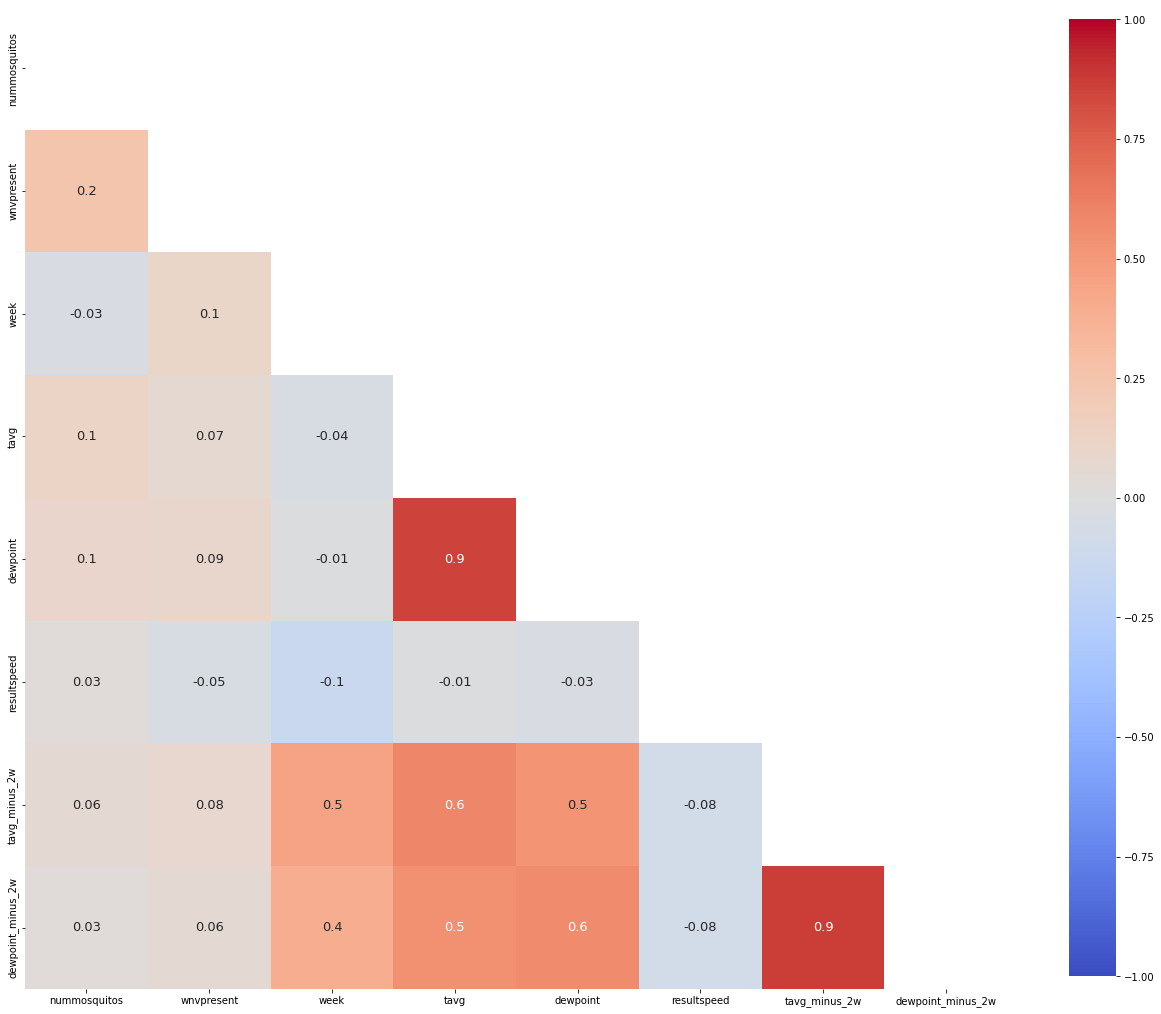

In [77]:
plot_heatmap(df)

Now let's begin with some `Polynomial` features to explore if we can improve the potential correlation of our selected features with our target.

In [79]:
num_df = df[['nummosquitos', 'week', 'tavg', 'dewpoint', 'resultspeed', 'tavg_minus_2w', 'dewpoint_minus_2w']]

We tested out multiple degrees for `polynomial features`, however we found that degree 2 works the best and the resultant features give us the highest correlation with our target.

In [91]:
poly = PolynomialFeatures(include_bias=False, degree=2)
poly_features = poly.fit_transform(num_df)
poly_features.shape

(9693, 35)

In [92]:
poly_features = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(num_df.columns))

In [93]:
poly_corr = poly_features.corrwith(df['wnvpresent'])

In [100]:
abs(poly_corr).sort_values(ascending=False).tail(35-8-5)

dewpoint tavg_minus_2w             0.095333
week dewpoint_minus_2w             0.092057
dewpoint^2                         0.087627
dewpoint                           0.087043
tavg tavg_minus_2w                 0.080552
tavg dewpoint                      0.079799
dewpoint dewpoint_minus_2w         0.079039
tavg_minus_2w                      0.078887
tavg_minus_2w^2                    0.072698
tavg dewpoint_minus_2w             0.068062
tavg                               0.065243
tavg_minus_2w dewpoint_minus_2w    0.064240
tavg^2                             0.063102
dewpoint_minus_2w                  0.061878
dewpoint_minus_2w^2                0.052453
resultspeed                        0.045893
resultspeed^2                      0.043516
tavg resultspeed                   0.029220
dewpoint resultspeed               0.024323
resultspeed tavg_minus_2w          0.017287
week resultspeed                   0.015033
resultspeed dewpoint_minus_2w      0.011239
dtype: float64

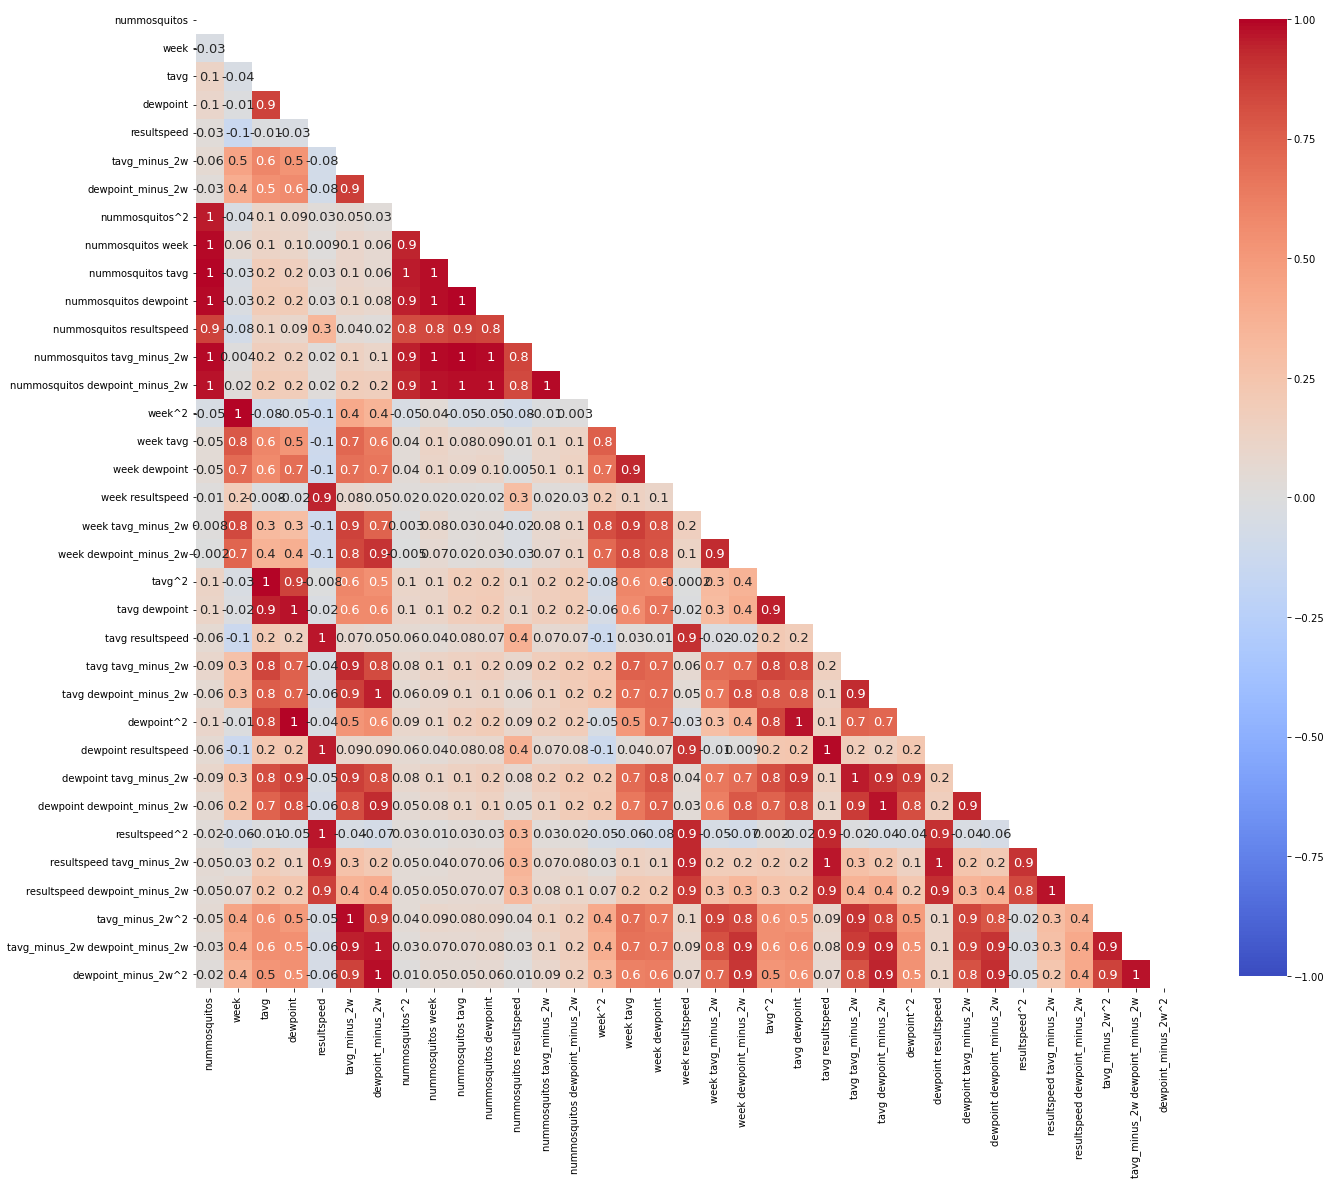

In [95]:
plot_heatmap(poly_features)

We seem to have found some very interesting features, with more than double the highest correlation that we saw. However there is clearly a lot of multicollinearity within these features, we will have to carefully select the feautures that we will add to our train dataset, with reference to the above heatmap as well as the list of feature names and correlation score. The selected features are listed below.

Poly Features` that we are selecting, and the corressponding feature to drop from our training dataframe due to pairwise correlation/multicollinearity if any:
* nummosquitos week, drop: nummosquitos
* week dewpoint, drop: dewpoint
* week tavg_minus_2w, drop: tavg_minus_2w

Introducing any of the other points may introduce too much multi-collinearity, so we will stick with these three for now.

In [101]:
df['nummosquitos*week'] = df['nummosquitos']*df['week']
df['week*dewpoint'] = df['week']*df['dewpoint']
df['week*tavg_minus_2w'] = df['week']*df['tavg_minus_2w']

df.drop(columns=['nummosquitos', 'dewpoint', 'tavg_minus_2w'], inplace=True)

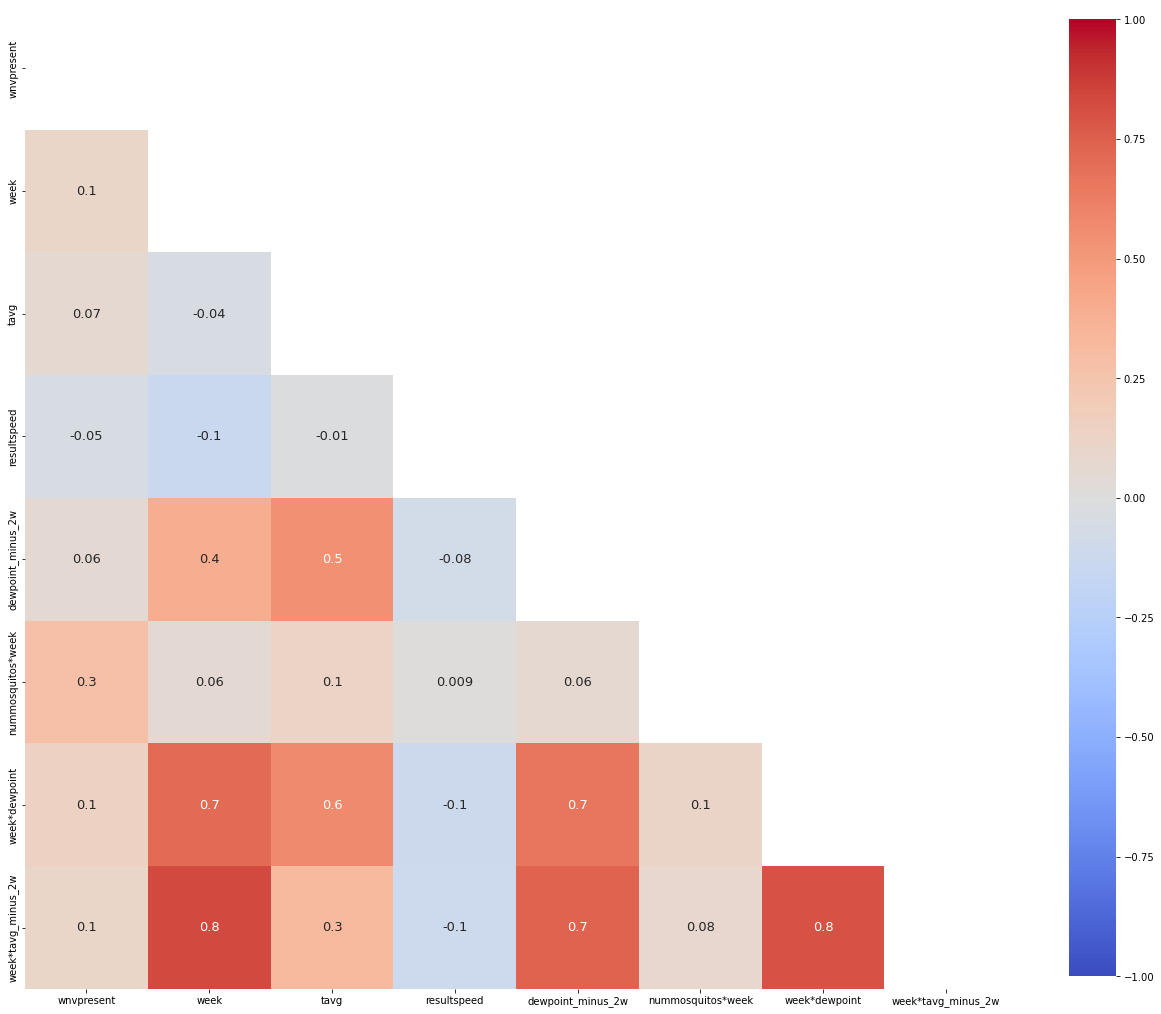

In [102]:
plot_heatmap(df)

In [104]:
abs(df.corr()['wnvpresent']).sort_values(ascending=False)

wnvpresent            1.000000
nummosquitos*week     0.274450
week*dewpoint         0.143741
week*tavg_minus_2w    0.105639
week                  0.104807
tavg                  0.065243
dewpoint_minus_2w     0.061878
resultspeed           0.045893
Name: wnvpresent, dtype: float64

Based on the above heatmap, due to some multicollinearity, we will choose to drop a few additional features:
* `week`
* REMAINDER TO CHECK WITH DAREN AND DICKSON

## One-Hot Encoding / Dummifying

Now the last step for us to take is going to be one hot encoding, before we replicate the steps taken to the `test` data set.

In [ ]:
# dummification of 'trap', 'codesum', and 'species'


And lastly we will drop the `date` feature from our DataFrame and with that we are ready to begin modeling.

In [107]:
df.drop(columns=['date'], inplace=True)

However before we begin modeling, we will need to address the imbalance between our two classes using either an undersampling or oversampling technique. This will be covered in the next notebook.